In [71]:
import os
import shap
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, roc_curve, classification_report, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.6f' % x)


## Input 

The main input of this notebook is a `csv` file including processed features and labels for all videos. 

In [72]:
TOTAL_DATASET = 'processed_feature/total_dataset.csv'

DL_TRAIN_DATASET = "full_dataset_train.json"
DL_TEST_DATASET = "full_dataset_test.json"


In [73]:

trainset = pickle.load(open(DL_TRAIN_DATASET,'rb'))
testset = pickle.load(open(DL_TEST_DATASET,'rb'))


In [74]:
trainset_code = trainset['train_creative_code']
testset_code = testset['test_creative_code']
print(len(trainset_code), len(testset_code))

980 246


In [64]:
def evaluate_best_model(grid_search, X_test, y_test, threshold=None):
    if threshold==None: 
        # Evaluate the best model on the test set
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        print("Classification Report for Best Model (Threshold=0.5):")
        print(classification_report(y_test, y_pred))

        # Calculate and print ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"\nROC AUC Score: {roc_auc:.2f}")
        
        return best_model, y_pred_proba    
    else: 
        best_model = grid_search.best_estimator_
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)

        # Print classification report
        print("\nClassification Report (Threshold = {threshold}):".format(threshold=threshold))
        print(classification_report(y_test, y_pred_threshold))

        # Calculate and print ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"\nROC AUC Score: {roc_auc:.2f}")

def evaluate_default(predictions, test_labels, threshold=0.5):
    predictions_binary = (predictions > threshold).astype(int)

    accuracy = accuracy_score(test_labels, predictions_binary)
    precision = precision_score(test_labels, predictions_binary)
    recall = recall_score(test_labels, predictions_binary)
    f1 = f1_score(test_labels, predictions_binary)
    auc = roc_auc_score(test_labels, predictions)

    print(f"Test Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    
    
     # Print classification report
    print("\n"+"*"*30+"Classification Report (Threshold = {threshold}):".format(threshold=0.5))
    print(classification_report(test_labels, predictions_binary))
    print(confusion_matrix(test_labels, predictions_binary.reshape(-1)))

def plot_metrics_vs_threshold(y_test, predictions):
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    
    plot_ths = []
    recall_at_thresholds = []
    precision_at_thresholds = []
    f1_at_thresholds = []
    marco_recall_thresholds = []
    best_marco_recall = -10e100
    best_marco_recall_threshold = 0
    # Calculate recall, precision, and F1 score at each threshold
    for threshold in thresholds:
        if threshold > 1: continue 
        y_pred_threshold = (predictions > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average=None)
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_threshold, average='macro')
        recall_at_thresholds.append(recall[1])
        precision_at_thresholds.append(precision[1])
        f1_at_thresholds.append(f1[1])
        marco_recall_thresholds.append(recall_macro)
        plot_ths.append(threshold)
        # print(round(threshold,2), recall_macro)
        if (recall_macro > best_marco_recall) and (recall[0] > 0.7) and (recall[1] > 0.3):
            best_marco_recall = recall_macro
            best_marco_recall_threshold = threshold
    
    print("\n"+"*"*30+"Evaluate metrics vs. Threshold for true class + Marco Recall")
        
    # Plot the metrics
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True)

    # Plot recall vs. threshold
    axs[0].plot(plot_ths, recall_at_thresholds, label='Recall', color='blue')
    axs[0].set_xlabel('Threshold')
    axs[0].set_xlim([0,1])
    axs[0].set_ylabel('Recall')
    axs[0].set_title('Recall vs. Threshold')
    axs[0].legend()
    axs[0].grid(True)

    # Plot precision vs. threshold
    axs[1].plot(plot_ths, precision_at_thresholds, label='Precision', color='green')
    axs[1].set_xlabel('Threshold')
    axs[0].set_xlim([0,1])
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision vs. Threshold')
    axs[1].legend()
    axs[1].grid(True)

    # Plot F1 score vs. threshold
    axs[2].plot(plot_ths, f1_at_thresholds, label='F1 Score', color='red')
    axs[2].set_xlabel('Threshold')
    axs[0].set_xlim([0,1])
    axs[2].set_ylabel('F1 Score')
    axs[2].set_title('F1 Score vs. Threshold')
    axs[2].legend()
    axs[2].grid(True)

    # Plot F1 score vs. threshold
    axs[3].plot(plot_ths, marco_recall_thresholds, label='Marco Recall', color='black')
    axs[3].set_xlabel('Threshold')
    axs[0].set_xlim([0,1])
    axs[3].set_ylabel('Marco Recall')
    axs[3].set_title('Marco Recall vs. Threshold')
    axs[3].legend()
    axs[3].grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

    print()
    
    print('best recall_macro', best_marco_recall)
    print('best_marco_recall_threshold', best_marco_recall_threshold)
    if best_marco_recall_threshold > 0:
        evaluate_default(predictions, y_test, best_marco_recall_threshold)
    else: 
        print('Cannot Beat Baseline.')


## Ingest Dataset 

In [76]:
data_processed_w_music = pd.read_csv(TOTAL_DATASET)

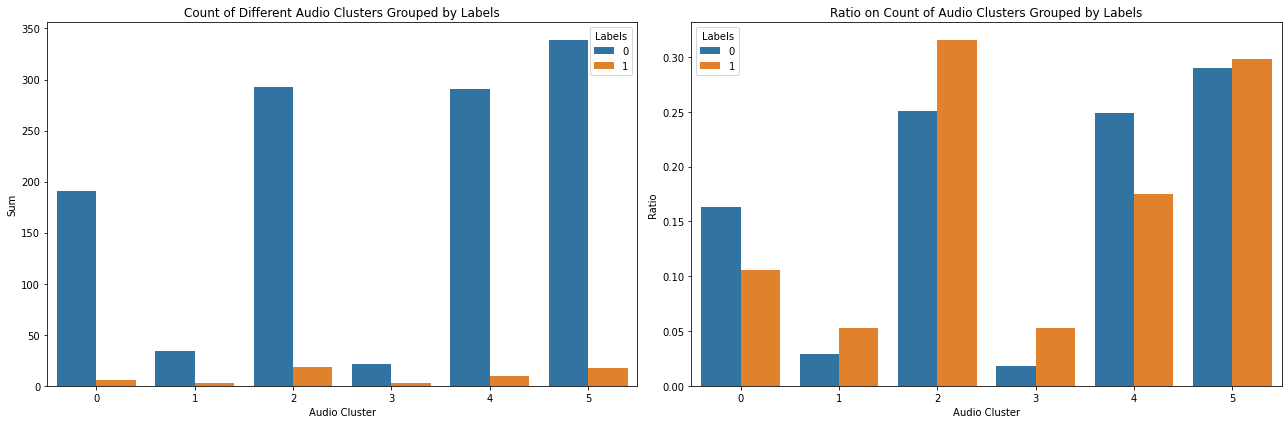

In [85]:
# import seaborn as sns

# data_sum = data_processed_w_music.groupby('labels')[
#     ['audio_cluster_0', 'audio_cluster_1', 'audio_cluster_2', 'audio_cluster_3', 'audio_cluster_4', 'audio_cluster_5']
# ].sum()

# data_ratio = data_sum.div(data_sum.sum(axis=1), axis=0)

# data_sum = data_sum.reset_index()
# data_ratio = data_ratio.reset_index()
# data_melted_sum = data_sum.melt(id_vars='labels', var_name='Audio Cluster', value_name='Sum')
# data_melted_sum['Audio Cluster'] = data_melted_sum['Audio Cluster'].str.replace('audio_cluster_','')
# data_melted_ratio = data_ratio.melt(id_vars='labels', var_name='Audio Cluster', value_name='Ratio')
# data_melted_ratio['Audio Cluster'] = data_melted_ratio['Audio Cluster'].str.replace('audio_cluster_','')

# fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# sns.barplot(x='Audio Cluster', y='Sum', hue='labels', data=data_melted_sum, ax=axes[0])
# axes[0].set_title('Count of Different Audio Clusters Grouped by Labels')
# axes[0].set_xlabel('Audio Cluster')
# axes[0].set_ylabel('Sum')
# sns.barplot(x='Audio Cluster', y='Ratio', hue='labels', data=data_melted_ratio, ax=axes[1])
# axes[1].set_title('Ratio on Count of Audio Clusters Grouped by Labels')
# axes[1].set_xlabel('Audio Cluster')
# axes[1].set_ylabel('Ratio')
# for ax in axes:
#     ax.legend(title='Labels')
#     # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# plt.tight_layout()
# plt.show()

In [1]:
# data_processed_w_music[data_processed_w_music['labels']==1].head()

In [8]:
# print('\n'.join(data_processed_w_music.columns))

In [9]:
label_dict = {row['creative_code']: int(row['labels']) for i, row in data_processed_w_music[['creative_code', 'labels']].iterrows()}
X_columns = [x for x in data_processed_w_music.columns if x not in ['creative_code', 'labels']]

In [2]:
# data_processed_w_music.groupby(['labels', 'audio_cluster'])['labels'].count()
# data_processed_w_music.head()

In [11]:

def custom_train_test_split(data_processed_w_music, trainset_code, testset_code, X_columns=None):
    if X_columns is None:
        X_columns = [x for x in data_processed_w_music.columns if x not in ['creative_code', 'labels']]
    Y_columns = 'labels'

    X = data_processed_w_music[X_columns]
    y = data_processed_w_music[Y_columns].astype(int)

    X.index=data_processed_w_music['creative_code']
    y.index=data_processed_w_music['creative_code']
    # X = X.reset_index(drop=True)
    # y = y.reset_index(drop=True)

    # Split the dataset into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = X[X.index.isin(trainset_code)]
    X_test = X[X.index.isin(testset_code)]
    y_train = y[y.index.isin(trainset_code)].astype(int)
    y_test = y[y.index.isin(testset_code)].astype(int)
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    return X_train, X_test, y_train, y_test



## Model 0: Baseline - Domain Rule Based


## Model 1: LogisticRegression

In [16]:
X_train, X_test, y_train, y_test = custom_train_test_split(data_processed_w_music, trainset_code, testset_code)

imp = SimpleImputer(strategy='most_frequent')  
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(980, 249)
(246, 249)
(980,)
(246,)
(980, 249)
(246, 249)
(980,)
(246,)


In [26]:

# Define a pipeline combining feature selection and logistic regression
pipeline = Pipeline([
    ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42))),
    ('classification', LogisticRegression(random_state=42))
    # ('classification', LogisticRegression())
])
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
# ‘liblinear’ and ‘newton-cholesky’ can only handle binary classification by default. To apply a one-versus-rest scheme for the multiclass setting one can wrapt it with the OneVsRestClassifier.

param_grid = {
    'feature_selection__estimator__C': [0.1, 1, 10],
    'classification__C': [0.1, 1, 10],
    'classification__solver': ['lbfgs', 'liblinear'],
    'classification__class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}],
    'classification__max_iter': [100, 500, 1000]
}

scorer = make_scorer(roc_auc_score, needs_proba=True)
grid_search_lr = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=5, verbose=1)

grid_search_lr.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_lr.best_params_}")
print(f"Best AUC: {grid_search_lr.best_score_:.2f}")



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Best Parameters: {'classification__C': 10, 'classification__class_weight': 'balanced', 'classification__max_iter': 100, 'classification__solver': 'lbfgs', 'feature_selection__estimator__C': 10}
Best AUC: 0.65


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [27]:
best_model_lr, y_pred_lr = evaluate_best_model(grid_search_lr, X_test, y_test)

Classification Report for Best Model (Threshold=0.5):
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       235
           1       0.10      0.45      0.16        11

    accuracy                           0.78       246
   macro avg       0.53      0.63      0.52       246
weighted avg       0.93      0.78      0.84       246


ROC AUC Score: 0.65


Test Accuracy: 0.7845528455284553
Precision: 0.09615384615384616
Recall: 0.45454545454545453
F1 Score: 0.15873015873015872
AUC: 0.6514506769825918

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       235
           1       0.10      0.45      0.16        11

    accuracy                           0.78       246
   macro avg       0.53      0.63      0.52       246
weighted avg       0.93      0.78      0.84       246

[[188  47]
 [  6   5]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


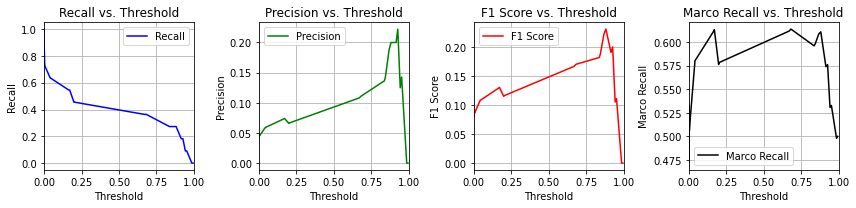


best recall_macro 0.6137330754352031
best_marco_recall_threshold 0.6822813705231661
Test Accuracy: 0.8414634146341463
Precision: 0.1111111111111111
Recall: 0.36363636363636365
F1 Score: 0.1702127659574468
AUC: 0.6514506769825918

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       235
           1       0.11      0.36      0.17        11

    accuracy                           0.84       246
   macro avg       0.54      0.61      0.54       246
weighted avg       0.93      0.84      0.88       246

[[203  32]
 [  7   4]]


In [65]:

evaluate_default(y_pred_lr, y_test)

plot_metrics_vs_threshold(y_test, y_pred_lr)


In [3]:

selected_features_mask = best_model_lr.named_steps['feature_selection'].get_support()
coefficients = best_model_lr.named_steps['classification'].coef_[0]
selected_feature_names = np.array(X_columns)[selected_features_mask]
feature_importance = pd.Series(coefficients, index=selected_feature_names)

feature_importance = feature_importance.sort_values(ascending=False)



In [4]:
# import seaborn as sns
# top_10 = feature_importance.head(10)
# last_10 = feature_importance.tail(10)
# combined_features = pd.concat([top_10, last_10])

# # Create a bar plot using seaborn
# plt.figure(figsize=(10, 6))
# sns.barplot(x=combined_features.values, y=combined_features.index, palette='viridis')
# plt.title('Top 10 and Last 10 Feature Importance for Logistic Regression')
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.show()

## Model 2: XGBOOST 

In [33]:
X_train, X_test, y_train, y_test = custom_train_test_split(data_processed_w_music, trainset_code, testset_code)


(980, 249)
(246, 249)
(980,)
(246,)


In [34]:
classifier = XGBClassifier(random_state=42, eval_metric='logloss')

param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.1, 0.01, 0.001],  
    'max_depth': [3, 6, 10],  
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 1.0], 
    'scale_pos_weight': [1, 10, np.sum(y_train == 0) / np.sum(y_train == 1)]  # Adjust class imbalance
}
# 2430 fits = 84m

scorer = make_scorer(roc_auc_score, needs_proba=True)
grid_search_xgb = GridSearchCV(classifier, param_grid, scoring=scorer, cv=5, verbose=1)
grid_search_xgb.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Best AUC: {grid_search_xgb.best_score_:.2f}")


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'scale_pos_weight': 20.304347826086957, 'subsample': 1.0}
Best AUC: 0.71


In [35]:
best_model_xgb, y_pred_xgb = evaluate_best_model(grid_search_xgb, X_test, y_test)

Classification Report for Best Model (Threshold=0.5):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       235
           1       0.25      0.18      0.21        11

    accuracy                           0.94       246
   macro avg       0.61      0.58      0.59       246
weighted avg       0.93      0.94      0.93       246


ROC AUC Score: 0.69


Test Accuracy: 0.9390243902439024
Precision: 0.25
Recall: 0.18181818181818182
F1 Score: 0.2105263157894737
AUC: 0.6870406189555126

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       235
           1       0.25      0.18      0.21        11

    accuracy                           0.94       246
   macro avg       0.61      0.58      0.59       246
weighted avg       0.93      0.94      0.93       246

[[229   6]
 [  9   2]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


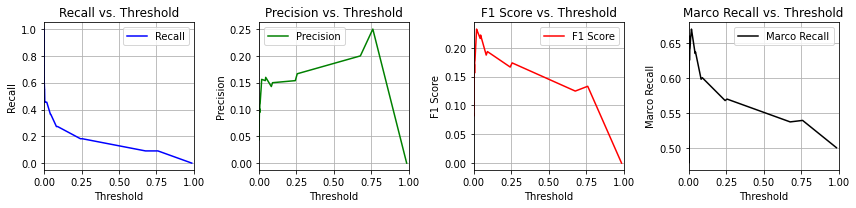


best recall_macro 0.669825918762089
best_marco_recall_threshold 0.018006869
Test Accuracy: 0.8658536585365854
Precision: 0.15625
Recall: 0.45454545454545453
F1 Score: 0.2325581395348837
AUC: 0.6870406189555126

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       235
           1       0.16      0.45      0.23        11

    accuracy                           0.87       246
   macro avg       0.56      0.67      0.58       246
weighted avg       0.94      0.87      0.90       246

[[208  27]
 [  6   5]]


In [67]:
evaluate_default(y_pred_xgb, y_test)
plot_metrics_vs_threshold(y_test, y_pred_xgb)


In [5]:

feature_importance = pd.Series(best_model_xgb.feature_importances_, index=X_columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)[:10]
print("Feature Importance:")
print(feature_importance_sorted) 


## Model 3: CATBOOST 


In [39]:
X_train, X_test, y_train, y_test = custom_train_test_split(data_processed_w_music, trainset_code, testset_code)

(980, 249)
(246, 249)
(980,)
(246,)


In [40]:

classifier = CatBoostClassifier(random_state=42, verbose=0)

param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [3, 6, 10],
    'subsample': [0.5, 0.8, 1.0],
    'scale_pos_weight': [1, 5, np.sum(y_train == 0) / np.sum(y_train == 1)]  # Adjust class imbalance
}
# 1215 fits 223m

scorer = make_scorer(roc_auc_score, needs_proba=True)
grid_search_cat = GridSearchCV(classifier, param_grid, scoring=scorer, cv=5, verbose=1)
grid_search_cat.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_cat.best_params_}")
print(f"Best AUC: {grid_search_cat.best_score_:.2f}")



Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'depth': 3, 'iterations': 1000, 'learning_rate': 0.1, 'scale_pos_weight': 5, 'subsample': 1.0}
Best AUC: 0.69


In [41]:

best_model_cat, y_pred_cat = evaluate_best_model(grid_search_cat, X_test, y_test)


Classification Report for Best Model (Threshold=0.5):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       235
           1       0.22      0.18      0.20        11

    accuracy                           0.93       246
   macro avg       0.59      0.58      0.58       246
weighted avg       0.93      0.93      0.93       246


ROC AUC Score: 0.67


Test Accuracy: 0.9349593495934959
Precision: 0.2222222222222222
Recall: 0.18181818181818182
F1 Score: 0.19999999999999998
AUC: 0.6738878143133463

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       235
           1       0.22      0.18      0.20        11

    accuracy                           0.93       246
   macro avg       0.59      0.58      0.58       246
weighted avg       0.93      0.93      0.93       246

[[228   7]
 [  9   2]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


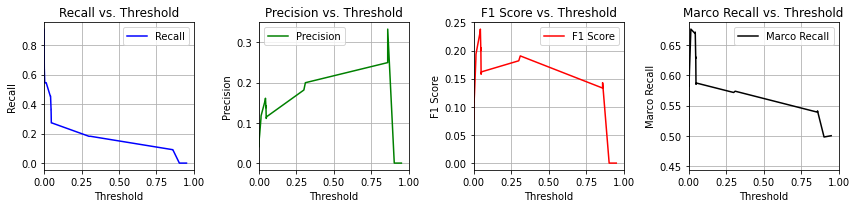


best recall_macro 0.6769825918762089
best_marco_recall_threshold 0.014067977921024688
Test Accuracy: 0.7967479674796748
Precision: 0.11764705882352941
Recall: 0.5454545454545454
F1 Score: 0.1935483870967742
AUC: 0.6738878143133463

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       235
           1       0.12      0.55      0.19        11

    accuracy                           0.80       246
   macro avg       0.55      0.68      0.54       246
weighted avg       0.94      0.80      0.85       246

[[190  45]
 [  5   6]]


In [68]:
evaluate_default(y_pred_cat, y_test)

plot_metrics_vs_threshold(y_test, y_pred_cat)


In [6]:

# feature_importance = pd.Series(best_model_cat.feature_importances_, index=X_columns)
# feature_importance_sorted = feature_importance.sort_values(ascending=False)[:10]
# print("Feature Importance:")
# print(feature_importance_sorted) 


## Model 4: RF  

In [44]:
X_train, X_test, y_train, y_test = custom_train_test_split(data_processed_w_music, trainset_code, testset_code)

imp = SimpleImputer(strategy='most_frequent') # 也可以选择'median'等其他填充策略
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

(980, 249)
(246, 249)
(980,)
(246,)


In [45]:

classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 10}, {0: 1, 1: 5}]
}
# 3240 fits 44m

scorer = make_scorer(roc_auc_score, needs_proba=True)
grid_search_rf = GridSearchCV(classifier, param_grid, scoring=scorer, cv=5, verbose=1)
grid_search_rf.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Best AUC: {grid_search_rf.best_score_:.2f}")



Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000}
Best AUC: 0.66


In [46]:

best_model_rf, y_pred_rf = evaluate_best_model(grid_search_rf, X_test, y_test)


Classification Report for Best Model (Threshold=0.5):
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       235
           1       0.18      0.27      0.21        11

    accuracy                           0.91       246
   macro avg       0.57      0.61      0.58       246
weighted avg       0.93      0.91      0.92       246


ROC AUC Score: 0.64


Test Accuracy: 0.9105691056910569
Precision: 0.17647058823529413
Recall: 0.2727272727272727
F1 Score: 0.21428571428571427
AUC: 0.6390715667311412

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       235
           1       0.18      0.27      0.21        11

    accuracy                           0.91       246
   macro avg       0.57      0.61      0.58       246
weighted avg       0.93      0.91      0.92       246

[[221  14]
 [  8   3]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


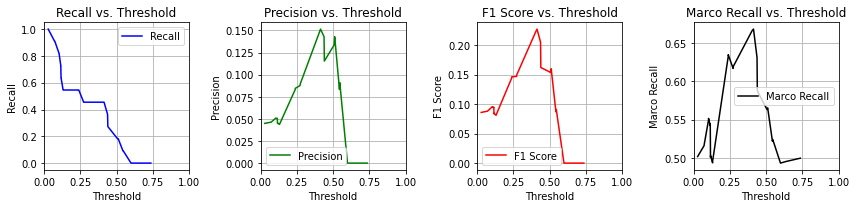


best recall_macro 0.6676982591876209
best_marco_recall_threshold 0.4135221056675157
Test Accuracy: 0.8617886178861789
Precision: 0.15151515151515152
Recall: 0.45454545454545453
F1 Score: 0.22727272727272727
AUC: 0.6390715667311412

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       235
           1       0.15      0.45      0.23        11

    accuracy                           0.86       246
   macro avg       0.56      0.67      0.58       246
weighted avg       0.94      0.86      0.89       246

[[207  28]
 [  6   5]]


In [69]:
evaluate_default(y_pred_rf, y_test)

plot_metrics_vs_threshold(y_test, y_pred_rf)


In [7]:

# Feature importance
feature_importance = pd.Series(best_model_rf.feature_importances_, index=X_columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)[:10]
print("Feature Importance:")
print(feature_importance_sorted) 


## Model 5: Soft Voting

In [49]:
X_train, X_test, y_train, y_test = custom_train_test_split(data_processed_w_music, trainset_code, testset_code)

imp = SimpleImputer(strategy='most_frequent') # 也可以选择'median'等其他填充策略
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)
 

(980, 249)
(246, 249)
(980,)
(246,)


In [51]:
voting_clf = VotingClassifier(estimators=[
    ('rf', best_model_rf), 
    ('lr', best_model_lr), 
    ('xgb', best_model_xgb), 
    ('cat', best_model_cat)
], voting='soft')  # use 'hard' for majority voting


voting_clf.fit(X_train,y_train)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     max_features='log2',
                                                     min_samples_leaf=4,
                                                     n_estimators=1000,
                                                     random_state=42)),
                             ('lr',
                              Pipeline(steps=[('feature_selection',
                                               SelectFromModel(estimator=LogisticRegression(C=10,
                                                                                            max_iter=1000,
                                                                                            penalty='l1',
                                                                                            random_state=42,
    

In [52]:
y_pred_voting = voting_clf.predict(X_test)
y_pred_prob_voting = voting_clf.predict_proba(X_test)[:, 1]

print("\nClassification Report (Threshold = 0.5):")
print(classification_report(y_test, y_pred_voting))
roc_auc = roc_auc_score(y_test, y_pred_prob_voting)

print(f'Voting Classifier AUC: {roc_auc:.2f}')


Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       235
           1       0.27      0.27      0.27        11

    accuracy                           0.93       246
   macro avg       0.62      0.62      0.62       246
weighted avg       0.93      0.93      0.93       246

Voting Classifier AUC: 0.67


Test Accuracy: 0.9349593495934959
Precision: 0.2727272727272727
Recall: 0.2727272727272727
F1 Score: 0.2727272727272727
AUC: 0.6657640232108317

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       235
           1       0.27      0.27      0.27        11

    accuracy                           0.93       246
   macro avg       0.62      0.62      0.62       246
weighted avg       0.93      0.93      0.93       246

[[227   8]
 [  8   3]]

******************************Evaluate metrics vs. Threshold for true class + Marco Recall


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


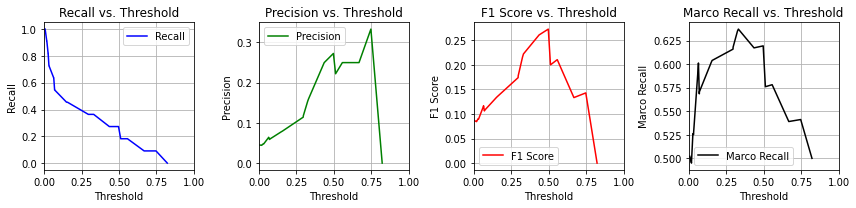


best recall_macro 0.637137330754352
best_marco_recall_threshold 0.3312777948434526
Test Accuracy: 0.8861788617886179
Precision: 0.16
Recall: 0.36363636363636365
F1 Score: 0.2222222222222222
AUC: 0.6657640232108317

******************************Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       235
           1       0.16      0.36      0.22        11

    accuracy                           0.89       246
   macro avg       0.56      0.64      0.58       246
weighted avg       0.93      0.89      0.91       246

[[214  21]
 [  7   4]]


In [70]:
evaluate_default(y_pred_prob_voting, y_test)

plot_metrics_vs_threshold(y_test, y_pred_prob_voting)


## Summary 

In [54]:

def evaluate_classification(y_true, y_pred_proba):
    y_pred = (np.array(y_pred_proba) > 0.5).astype(int)
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    return {
        'AUC': auc,
        'Accuracy': accuracy,
        '0-Precision': precision[0],
        '0-Recall': recall[0],
        '0-F1-Score': f1[0],
        '1-Precision': precision[1],
        '1-Recall': recall[1],
        '1-F1-Score': f1[1],
        'Macro-Precision': precision_macro,
        'Macro-Recall': recall_macro,
        'Macro-F1-Score': f1_macro,
        'Weighted-Precision': precision_weighted,
        'Weighted-Recall': recall_weighted,
        'Weighted-F1-Score': f1_weighted
    }



In [55]:

# Evaluate models
results_baseline = evaluate_classification(y_test, y_pred_baseline)

results_lr = evaluate_classification(y_test, y_pred_lr)

results_lr_expert = evaluate_classification(y_test, y_pred_lr_exprt)

results_xgb = evaluate_classification(y_test, y_pred_xgb)

results_cat = evaluate_classification(y_test, y_pred_cat)

results_rf = evaluate_classification(y_test, y_pred_rf)

results_voting = evaluate_classification(y_test, y_pred_prob_voting)


# Create a DataFrame
results_df = pd.DataFrame({
    'Baseline': results_baseline,
    'Logistic Regression': results_lr,
    'LR(4 features)': results_lr_expert,
    'XGBoost': results_xgb,
    'CATBoost': results_cat,
    'Random Forest': results_rf,
    'Soft Voting': results_voting
})

# Transpose the DataFrame for better readability
results_df = results_df.T

# print(results_df)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [56]:
def format_values(val):
    val = 100*val
    return f"{val:.0f}%"

# Apply formatting
styled_results_df = (results_df.style
    .format(format_values)
    .background_gradient(cmap='Greens')
    .set_properties(**{'width': '120px'}))

# Display the styled DataFrame
styled_results_df


,AUC,Accuracy,0-Precision,0-Recall,0-F1-Score,1-Precision,1-Recall,1-F1-Score,Macro-Precision,Macro-Recall,Macro-F1-Score,Weighted-Precision,Weighted-Recall,Weighted-F1-Score
Baseline,58%,77%,96%,79%,87%,7%,36%,12%,52%,58%,49%,92%,77%,83%
Logistic Regression,65%,78%,97%,80%,88%,10%,45%,16%,53%,63%,52%,93%,78%,84%
LR(4 features),48%,96%,96%,100%,98%,0%,0%,0%,48%,50%,49%,91%,96%,93%
XGBoost,69%,94%,96%,97%,97%,25%,18%,21%,61%,58%,59%,93%,94%,93%
CATBoost,67%,93%,96%,97%,97%,22%,18%,20%,59%,58%,58%,93%,93%,93%
Random Forest,64%,91%,97%,94%,95%,18%,27%,21%,57%,61%,58%,93%,91%,92%
Soft Voting,67%,93%,97%,97%,97%,27%,27%,27%,62%,62%,62%,93%,93%,93%


In [8]:
# from matplotlib.colors import LinearSegmentedColormap

# # Define a custom color map from red to green
# cmap = LinearSegmentedColormap.from_list("red_green", ["red", "white", "green"])

# # Normalize the feature values to a range between 0 and 1
# norm = plt.Normalize(features.min().min(), features.max().max())

# def apply_gradient(val):
#     if abs(val) >= 0.001: 
#         color = cmap(norm(val))
#         return 'background-color: rgba({}, {}, {}, {}); color: black'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255), color[3])
#     else: 
#         return 'color: white'
# def highlight_negative(data, features):
#     # Create a new DataFrame to hold the styles
#     styles = pd.DataFrame('', index=data.index, columns=data.columns)
    
#     # Iterate over the DataFrame and apply the style conditionally
#     for row in data.index:
#         for col in data.columns:
#             if col == 'MeanImportance': continue 
#             # if features.loc[row, col] < 0:
#             #     styles.loc[row, col] = 'color: red'
#             # elif features.loc[row, col] > 0:
#             #     styles.loc[row, col] = 'color: green'
#             value = features.loc[row, col]
#             styles.loc[row, col] = apply_gradient(value)
#     return styles

# styled_df = feature_importance_df.sort_values('MeanImportance', ascending=False).style.apply(lambda x: highlight_negative(x, features), axis=None)


# print("The values in the field show the feature importance. (Norm to 1 for each model) ")
# print("The color in the background of the field show the negative(red) or positive(green) impact on average. ")
# print("The darker it is, the higher the impact that feature has.")
# print("If the sum up between negative and positive shap values is too small (0.001), background color does not show. ")

# # Display the styled DataFrame
# styled_df
